In [26]:
import pickle
with open("/content/drive/MyDrive/WaterBalance_new/notebook/ds_array_4.pkl", "rb") as f:
    ds_array_4 = pickle.load(f)

with open("/content/drive/MyDrive/WaterBalance_new/notebook/Ea_pyet.pkl", "rb") as f:
    Ea_pyet = pickle.load(f)

Ea_pyet
ds_array_4

<xarray.Dataset>
Dimensions:             (time: 1, y: 13, x: 20)
Coordinates:
  * x                   (x) float32 -109.3 -109.2 -109.1 ... -107.5 -107.4
  * y                   (y) float32 44.55 44.45 44.35 ... 43.55 43.45 43.35
  * time                (time) datetime64[ns] 2022-01-31
    spatial_ref         int64 0
Data variables:
    precipitation       (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    runoff              (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    underground_runoff  (time, y, x) float64 nan nan nan nan ... nan nan nan nan
    soilmoisture        (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    sub_soilmoisture    (time, y, x) float32 nan nan nan nan ... nan nan nan nan
    shapefile           (y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    history:          Created on 2022-02-05 07:15
    input_data_hash:  27d78e1ad0241438dcb7b796dee6d7c1393f1b4522680997748376e...

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install netCDF4 geopandas wxee geemap rasterio rioxarray

In [30]:
import os
import sys
import pandas as pd
import numpy as np
import netCDF4 as nc
import xarray as xr
import geopandas as gpd
import ee
import wxee
import geemap
import rasterio
import rioxarray


sys.path.append('/content/drive/MyDrive/WaterBalance_new/')

from qdwb.soil_content.soil_content import *
from qdwb.soil_content.constant import *

In [10]:
ee.Authenticate()
wxee.Initialize()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=Bo30JqBydKJHObT2UaZznZoDKNnk38_IYwUHnoUCEOk&tc=QcvxWVZrIGg4KxFlk8cCrVQgjWqPr5cdhPEG3n2fTlM&cc=A76imQQBxpjQ-ADmnvBmTn0tzYoZtyNkBmM5h6qPeQw

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VNNz9fH606DgxXUn94PNV26bh6KyZmX6eSkt1XcxkXthV_IZ48xjqU

Successfully saved authorization token.


In [32]:
Map = geemap.Map()
Map.add_basemap('HYBRID')

# USA
LAT_MIN = 43.30
LAT_MAX = 44.60
LON_MIN = -109.40
LON_MAX = -107.40

# Soil depths [in cm] where we have data.
olm_depths = [0, 10, 30, 60, 100, 200]

# Names of bands associated with reference depths.
olm_bands = ["b" + str(sd) for sd in olm_depths]

def get_soil_prop(param):
    """
    This function returns soil properties image
    param (str): must be one of:
        "sand"     - Sand fraction
        "clay"     - Clay fraction
        "orgc"     - Organic Carbon fraction
    """
    if param == "sand":  # Sand fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "clay":  # Clay fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "orgc":  # Organic Carbon fraction [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 5 * 0.001  # to get kg/kg
    else:
        return print("error")

    # Apply the scale factor to the ee.Image.
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset


# Image associated with the sand content.
sand = get_soil_prop("sand")

# Image associated with the clay content.
clay = get_soil_prop("clay")

# Image associated with the organic carbon content.
orgc = get_soil_prop("orgc")

# Map.centerObject(shape, 9)
# Map.addLayer(sand, {'min':1, 'max':100}, 'sand')
# Map
shape = ee.Geometry.Rectangle([LON_MAX,LAT_MIN,LON_MIN,LAT_MAX])
sand_w = sand.clip(shape)
sand_w = sand_w.set("system:time_start", ee.Date("2022-01-31"))
arr = sand_w.wx.to_xarray(scale=250, crs='EPSG:4326')
arr

Downloading:   0%|          | 0.00/2.16M [00:00<?, ?iB/s]

<xarray.Dataset>
Dimensions:  (time: 1, y: 582, x: 892)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-31
  * y        (y) float64 44.6 44.6 44.6 44.6 44.6 ... 43.31 43.31 43.3 43.3 43.3
  * x        (x) float64 -109.4 -109.4 -109.4 -109.4 ... -107.4 -107.4 -107.4
Data variables:
    b0       (time, y, x) float64 nan nan nan nan nan ... 0.41 0.41 0.41 0.41
    b10      (time, y, x) float64 nan nan nan nan nan ... 0.39 0.41 0.41 0.4
    b30      (time, y, x) float64 nan nan nan nan nan ... 0.38 0.4 0.4 0.41 0.4
    b60      (time, y, x) float64 nan nan nan nan nan ... 0.41 0.42 0.44 0.42
    b100     (time, y, x) float64 nan nan nan nan nan ... 0.45 0.45 0.46 0.45
    b200     (time, y, x) float64 nan nan nan nan nan ... 0.45 0.45 0.47 0.46
Attributes:
    transform:               (0.002245788210298804, 0.0, -109.40132687649593,...
    crs:                     +init=epsg:4326
    res:                     (0.002245788210298804, 0.002245788210298804)
    is_tiled:                1
    nodatavals:              (-32768.0,)
    scales:                  (1.0,)
    offsets:                 (0.0,)
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [38]:
# da = arr.rio.write_crs("epsg:4326", inplace=True)
xds_repr_match = arr.rio.reproject_match(Ea_pyet, resampling = rasterio.enums.Resampling.nearest)
xds_repr_match


CRSError: ignored

In [ ]:
# Conversion of organic carbon content into organic matter content.
orgm = orgc.multiply(1.724)

# Organic matter content profile.
profile_orgm = local_profile(orgm, poi, scale)
print("Organic Matter content profile at the location of interest:\n", profile_orgm)

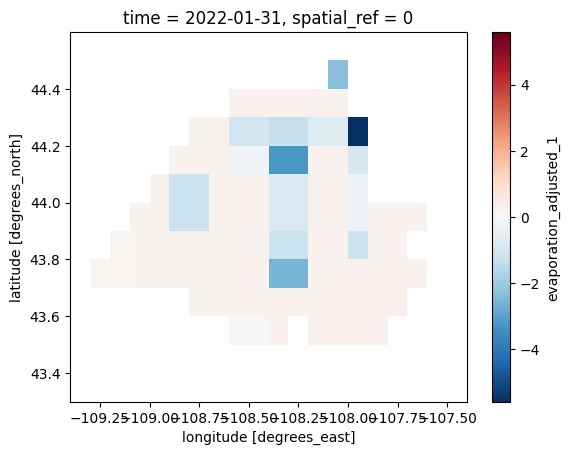

In [ ]:

# soil_water_content_of_evaporation_layer_at_previous_step = xds_repr_match__soilmoisture
# infiltration = underground_runoff
# evaporation = E_a_pyet
# field_capacity_soil_water_content_of_evaporation_layer = 60
# permanent_wilting_point_soil_water_content_of_evaporation_layer = 15
# coverd = True
# infiltration_to_transpiration_layer = 2
# infiltration_to_transition_layer = 0

# temp_1 = (soil_water_content_of_evaporation_layer_at_previous_step.ssm.values) + (infiltration.underground_runoff.values) - (evaporation.Hargreaves.values) - (infiltration_to_transpiration_layer)

Ea_pyet = list(Ea_pyet.Hargreaves.values.flatten())
underground_runoff = list(ds_array_4.underground_runoff.values.flatten())
soil = list(ds_array_4.soilmoisture.values.flatten())

soil_moisture_in_current_step_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = 30,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = 10,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[0]
for i, j, z in zip(Ea_pyet, underground_runoff, soil)])

evaporation_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = 30,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = 10,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[1]
for i, j, z in zip(Ea_pyet, underground_runoff, soil)])

infiltration_to_transpiration_layer_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = 30,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = 10,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[2]
for i, j, z in zip(Ea_pyet, underground_runoff, soil)])

infiltration_to_transition_layer_adjusted_1 = np.array([SoilContent.evaporation_layer(
    soil_water_content_of_evaporation_layer_at_previous_step = float(z),
    infiltration = float(j),
    evaporation = float(i),
    field_capacity_soil_water_content_of_evaporation_layer = 30,
    permanent_wilting_point_soil_water_content_of_evaporation_layer = 10,
    coverd = True,
    infiltration_to_transpiration_layer = 0
)[3]
for i, j, z in zip(Ea_pyet, underground_runoff, soil)])

soil_moisture_in_current_step_1 = soil_moisture_in_current_step_1.reshape(1,13,20)
evaporation_adjusted_1 = evaporation_adjusted_1.reshape(1,13,20)
infiltration_to_transpiration_layer_adjusted_1 = infiltration_to_transpiration_layer_adjusted_1.reshape(1,13,20)
infiltration_to_transition_layer_adjusted_1 = infiltration_to_transition_layer_adjusted_1.reshape(1,13,20)


ds_array_5 = ds_array_4.assign(soil_moisture_in_current_step_1_evaporation_layer=(['time', 'y', 'x'], soil_moisture_in_current_step_1))
ds_array_6 = ds_array_5.assign(evaporation_adjusted_1=(['time', 'y', 'x'], evaporation_adjusted_1))
ds_array_7 = ds_array_6.assign(infiltration_to_transpiration_layer_adjusted_1=(['time', 'y', 'x'], infiltration_to_transpiration_layer_adjusted_1))
ds_array_8 = ds_array_7.assign(infiltration_to_transition_layer_adjusted_1=(['time', 'y', 'x'], infiltration_to_transition_layer_adjusted_1))

# ds_array.soil_moisture_in_current_step_evaporation_layer.plot()
ds_array_8.evaporation_adjusted_1.plot()


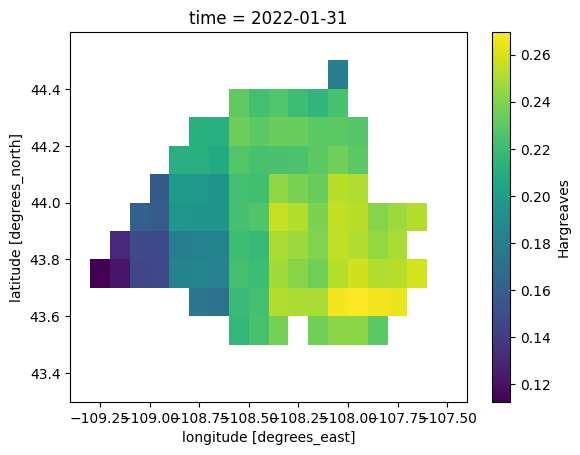

In [ ]:
with open("/content/drive/MyDrive/WaterBalance_new/notebook/Ea_pyet.pkl", "rb") as f:
    Ea_pyet = pickle.load(f)

Ea_pyet.Hargreaves.plot()